In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
#import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.sparse import diags
%matplotlib inline

<font color=red size=3>
    - Due to the issue of 20yr Treasure data(too short), all implementations below are without this dataset <br>
    - The original data is in "Interest rate.xlsx"
</font>

In [2]:
path_base = "libor_only.xlsx"
path_sofr = "sofr_only.xlsx"

def rename(path):
    """
    @Arg:
    path: path to file
    
    @Return:
    The raw data is terrible, return a better one where column names are sheet names of each
    """
    df_dict = pd.read_excel(path, sheet_name = None, index_col=0)
    df = pd.concat(df_dict.values(), axis=1)
    df.columns = list(df_dict.keys())
    
    return df
    

def merge_sofr(drop, path_base, path_sofr, libor = ["3mo_libor", "1mo_libor"]):
    """
    @Arg:
    drop: if we drop all NA
    path_base: path to the table of all basic data as well as libor
    path_sofr: path to table of sofr data
    libor: colname of libor, it will be used when we are updating them according with sofr
    
    @Return:
    Return a concatenated table of based on libor and sofr.
    Older data are with libor, and the newer one are replaced by sofr
    """
    
    df_base = rename(path_base)
    #display(df_base.loc["1985"])
    df_sofr = rename(path_sofr)
    #display(df_base)
    #display(df_sofr)
    
    df_sofr.columns = libor
    df_base.update(df_sofr)
    #display(df_base.loc["1985"])
    
    if drop:
        df_base = df_base.dropna(axis=0, how="any")
        #display(df_base)
        df_index = df_base.index
        df_base = df_base.reset_index(drop=True)
    
    return df_base, df_index

In [3]:
df, df_index = merge_sofr(True, path_base, path_sofr)

,30yr,10yr,5yr,2yr,1yr,6mo,3mo_libor,1mo_libor,1d
0,11.5730,11.5380,11.1770,10.3990,9.5820,9.1100,9.38000,9.19000,8.93
1,11.6720,11.6560,11.2910,10.4520,9.6040,9.1070,9.38000,9.19000,8.62
2,11.6110,11.6020,11.2330,10.3980,9.5520,9.0330,9.44000,9.25000,8.75
3,11.5720,11.5590,11.1850,10.3610,9.5030,8.9780,9.31000,9.13000,8.75
4,11.5120,11.4840,11.1190,10.2710,9.3630,8.8120,9.19000,9.00000,8.58
...,...,...,...,...,...,...,...,...,...
7679,4.1414,4.0123,4.1844,4.4142,4.5294,4.4756,4.43957,3.76771,3.08
7680,4.1639,4.0478,4.2283,4.4824,4.6019,4.5359,4.46029,3.80486,3.08
7681,4.0919,4.0419,4.2670,4.5447,4.6258,4.5838,4.45971,3.84157,3.08
7682,4.1405,4.1005,4.3093,4.6197,4.6945,4.5520,4.50843,3.83571,3.08


<AxesSubplot: >

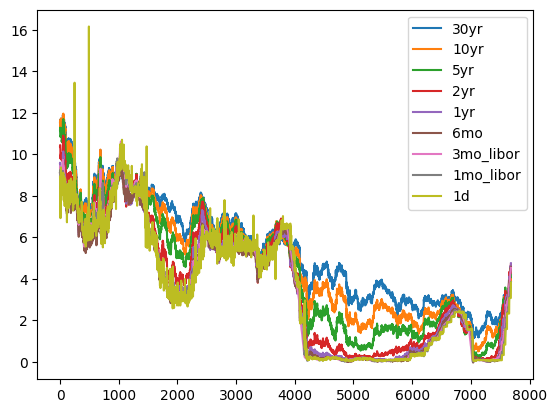

In [4]:
display(df)
df.plot()

<AxesSubplot: >

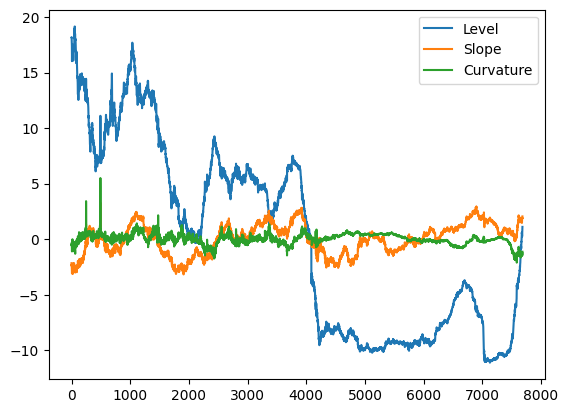

In [5]:
pca = PCA(n_components=3)
components = pca.fit_transform(df)
df_components = pd.DataFrame(data=components, columns=['Level', 'Slope', 'Curvature'])
df_components.plot() #???

<font color=red size=3>
    - According to the plot above(if it is indeed correct), should we use some model other than CIR? <br>
    - The real level produces is generally downward (is it?), while CIR always drift a process back to the mean.
</font>

# CIR

In [6]:
from dataclasses import dataclass
from typing import Optional, NoReturn


@dataclass
class CIRParams:
    """CIR process params, 2ab has to be larger or equal then c^2."""

    a: float  # mean reversion parameter
    b: float  # asymptotic mean
    c: float  # Brownian motion scale factor (standard deviation)

    def __post_init__(self) -> Optional[NoReturn]:
        #if 2 * self.a * self.b < self.c ** 2:
        #    raise ValueError("2ab has to be less than or equal to c^2.")
        return None

In [7]:
from typing import Optional, NoReturn, Any

import numpy as np

import brownian_motion

def get_CIR_process(
    N: int,
    T: int,
    CIR_params: CIRParams,
    sigma_0: Optional[float] = None,
    random_state: Optional[int] = None,
) -> np.ndarray:
    """
    @Arg:
    - N is the number of all simulated paths
    - T is the sample size.
    - CIR_params is an instance of CIRParams dataclass.
    - sigma_0 the initial value for the process, if None, then sigma_0 is taken
        to be b (the asymptotic mean).
        
    @Return:
    Returns a NxT array.
    """
    dW = brownian_motion.get_dW(N, T, random_state)
    return _generate_CIR_process(dW, CIR_params, sigma_0)


def _generate_CIR_process(
    dW: np.ndarray,
    CIR_params: CIRParams,
    sigma_0: Optional[float] = None,
) -> np.ndarray:
    """
    Generate the CIR process given the Brownian motion.
    
    @Arg:
    - dW is a NxT array with the Brownian motion increments.
    - CIR_params is an instance of CIRParams dataclass.
    - sigma_0 the initial value for the process, if None, then sigma_0 is taken
        to be b (the asymptotic mean).
        
    @Return
    Returns a NxT array.
    """
    N = len(dW)
    T = len(dW[0])
    _sigma_0 = _select_sigma_0(sigma_0, CIR_params)
    sigma_t = np.full((N, T), _sigma_0)
    for t in range(1, T):
        dsigma_t = (
            CIR_params.a * (CIR_params.b - sigma_t[:,t - 1])
            + CIR_params.c * np.sqrt(sigma_t[:,t - 1]) * dW[:,t]
        )
        #print(dsigma_t)
        # if Nan in simulation raise an error.
        _validate_not_nan(dsigma_t)
        sigma_t[:,t] = (sigma_t[:,t - 1] + dsigma_t)
    return np.asarray(sigma_t)


def _select_sigma_0(
    sigma_0_in: Optional[float], CIR_params: CIRParams
) -> float:
    """Returns sigma_0input if not None, else b (the long term mean)."""
    if sigma_0_in is not None:
        return sigma_0_in
    return CIR_params.b


def _validate_not_nan(dsigma_t: Any) -> Optional[NoReturn]:
    if np.isnan(dsigma_t).any():
        raise ValueError(
            "CIR process simulation crashed, check your CIR_params. "
            + "Maybe choose a smaller c value."
        )
    return None

In [8]:
import numpy as np
from sklearn.linear_model import LinearRegression


def estimate_CIR_params(sigma_t: np.ndarray) -> CIRParams:
    """
    Estimate CIR params from OLS regression.
    - sigma_t is 1D array.
    Returns instance of CIRParams.
    """
    # define regression specification
    sigma_sqrt = np.sqrt(sigma_t[:-1])
    y = np.diff(sigma_t) / sigma_sqrt
    x1 = 1.0 / sigma_sqrt
    x2 = sigma_sqrt
    X = np.concatenate([x1.reshape(-1, 1), x2.reshape(-1, 1)], axis=1)
    # regression model
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X, y)
    # regression coefficients
    ab = reg.coef_[0]
    a = -reg.coef_[1]
    b = ab / a
    # residuals and their standard deviation
    y_hat = reg.predict(X)
    c = np.std(y - y_hat)
    return CIRParams(a, b, c)

In [9]:
proc_level = df_components.Level.to_numpy()
proc_level += abs(min(proc_level)) + 0.001

est_param_level = estimate_CIR_params(proc_level)
print(est_param_level)

CIRParams(a=0.0015589263040421142, b=9.679545323496406, c=0.05003944374969426)


In [10]:
proc_level

array([29.28090615, 29.29953538, 29.27379992, ..., 11.73129664,
       11.83082711, 12.21097729])

In [11]:
plt.figure(figsize=(8, 4.5))

sim_level = get_CIR_process(1000, len(df_components), est_param_level, random_state = 42)
#temp = pd.DataFrame(sim_level.T)
#temp.plot()

<Figure size 800x450 with 0 Axes>

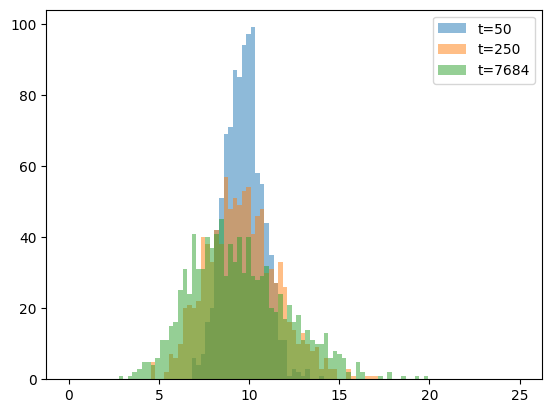

In [12]:
bins = np.linspace(0, 25, 100)

plt.hist(sim_level[:,50], bins, alpha=0.5, label="t=50")
plt.hist(sim_level[:,250], bins, alpha=0.5, label="t=250")
plt.hist(sim_level[:,-1], bins, alpha=0.5, label="t={length}".format(length=len(sim_level[0])))
plt.legend(loc="upper right")

plt.show()

In [13]:
#temp = np.array([np.histogram(sim_level[:i], bins = [i*3 for i in range(10)])[0] for i in range(1,100)])

In [14]:
#pd.DataFrame(temp.T)

In [15]:
#sns.heatmap(pd.DataFrame(temp.T))

In [16]:
#plt.imshow(temp.T, cmap='hot', interpolation='nearest', aspect='auto')

# OU

In [17]:
from dataclasses import dataclass
from typing import Optional, NoReturn


@dataclass
class OUParams:
    """OU process params."""

    a: float  # mean reversion parameter
    b: float  # asymptotic mean
    c: float

In [18]:
from typing import Optional, NoReturn, Any

import numpy as np

import brownian_motion

def get_OU_process(
    N: int,
    T: int,
    OU_params: OUParams,
    sigma_0: Optional[float] = None,
    random_state: Optional[int] = None,
) -> np.ndarray:
    """
    @Arg:
    - N: simulation size
    - T is the sample size.
    - OU_params is an instance of OUParams dataclass.
    - sigma_0 the initial value for the process, if None, then sigma_0 is taken
        to be b (the asymptotic mean).
        
    @Return:
    Returns a NxT array
    """
    dW = brownian_motion.get_dW(N, T, random_state)
    return _generate_OU_process(dW, OU_params, sigma_0)


def _generate_OU_process(
    dW: np.ndarray,
    OU_params: OUParams,
    sigma_0: Optional[float] = None,
) -> np.ndarray:
    """
    Generate the OU process given the Brownian motion.
    
    @Arg:
    - dW is a NxT array with the Brownian motion increments.
    - OU_params is an instance of OUParams dataclass.
    - sigma_0 the initial value for the process, if None, then sigma_0 is taken
        to be b (the asymptotic mean).
        
    @Return:
    Returns a 1D array.
    """
    N = len(dW)
    T = len(dW[0])
    _sigma_0 = _select_sigma_0(sigma_0, OU_params)
    sigma_t = np.full((N, T), _sigma_0)
    for t in range(1, T):
        dsigma_t = (
            OU_params.a * (OU_params.b - sigma_t[:,t - 1]) + OU_params.c * dW[:,t]
        )
        # if Nan in simulation raise an error.
        #_validate_not_nan(dsigma_t)
        sigma_t[:,t] = (sigma_t[:,t - 1] + dsigma_t)
    return np.asarray(sigma_t)


def _select_sigma_0(
    sigma_0_in: Optional[float], OU_params: OUParams
) -> float:
    """Returns sigma_0input if not None, else b (the long term mean)."""
    if sigma_0_in is not None:
        return sigma_0_in
    return OU_params.b


#def _validate_not_nan(dsigma_t: Any) -> Optional[NoReturn]:
#    if np.isnan(dsigma_t):
#        raise ValueError(
#            "OU process simulation crashed, check your OU_params. "
#            + "Maybe choose a smaller c value."
#        )
#    return None

In [19]:
import numpy as np
from sklearn.linear_model import LinearRegression


def estimate_OU_params(sigma_t: np.ndarray) -> OUParams:
    """
    Estimate OU params from OLS regression.
    - sigma_t is 1D array.
    Returns instance of CIRParams.
    """
    # define regression specification
    sigma = sigma_t[:-1]
    y = np.diff(sigma_t)
    x2 = sigma
    x1 = np.array([1.0]*len(x2))
    X = np.concatenate([x1.reshape(-1, 1), x2.reshape(-1, 1)], axis=1)
    # regression model
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X, y)
    # regression coefficients
    ab = reg.coef_[0]
    a = -reg.coef_[1]
    b = ab / a
    # residuals and their standard deviation
    y_hat = reg.predict(X)
    c = np.std(y - y_hat)
    return OUParams(a, b, c)

In [20]:
proc_slope = df_components.Slope.to_numpy()
proc_curvature = df_components.Curvature.to_numpy()

est_param_slope = estimate_OU_params(proc_slope)
est_param_curvature = estimate_OU_params(proc_curvature)
#print(est_param_slope)
#print(est_param_curvature)

In [21]:
sim_slope = get_OU_process(1000, len(df_components), est_param_slope, random_state = 42)
temp = pd.DataFrame(sim_slope.T)
#plt.hist(sim_slope[:,-1])
#temp.plot()

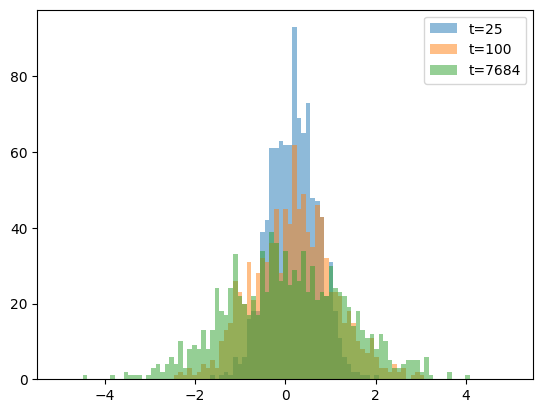

In [22]:
bins = np.linspace(-5, 5, 100)

plt.hist(sim_slope[:,25], bins, alpha=0.5, label="t=25")
plt.hist(sim_slope[:,100], bins, alpha=0.5, label="t=100")
plt.hist(sim_slope[:,-1], bins, alpha=0.5, label="t={length}".format(length=len(sim_level[0])))
plt.legend(loc="upper right")

plt.show()

In [23]:
sim_curvature = get_OU_process(1000, len(df_components), est_param_curvature, random_state = 42)
temp = pd.DataFrame(sim_curvature.T)
#plt.hist(sim_curvature[:,-1])
#temp.plot()

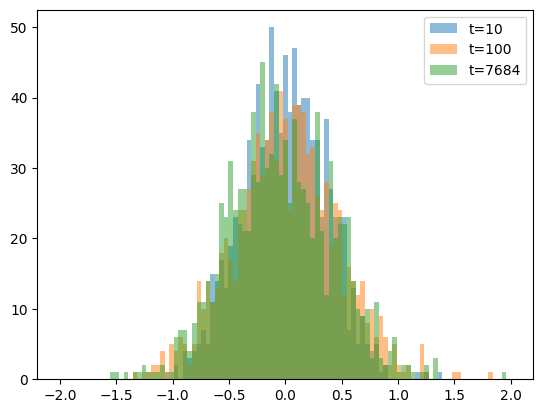

In [24]:
bins = np.linspace(-2, 2, 100)

plt.hist(sim_curvature[:,10], bins, alpha=0.5, label="t=10")
plt.hist(sim_curvature[:,100], bins, alpha=0.5, label="t=100")
plt.hist(sim_curvature[:,-1], bins, alpha=0.5, label="t={length}".format(length=len(sim_level[0])))
plt.legend(loc="upper right")

plt.show()

# Reconvert

In [25]:
recon_level = get_CIR_process(1, len(df_components), est_param_level, random_state = 42)
recon_slope = get_OU_process(1, len(df_components), est_param_slope, random_state = 42)
recon_curv = get_OU_process(1, len(df_components), est_param_curvature, random_state = 42)
recon = np.array([recon_level[0], recon_slope[0], recon_curv[0]]).T

In [26]:
data_recon = (recon @ pca.components_)
data_recon = data_recon + np.tile(df.mean().to_numpy(), (len(df), 1))
df_recon = pd.DataFrame(data_recon)
df_recon.columns = df.columns

<AxesSubplot: >

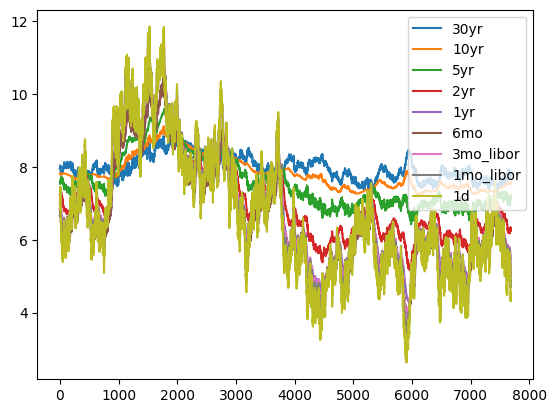

In [27]:
df_recon.plot()

<AxesSubplot: >

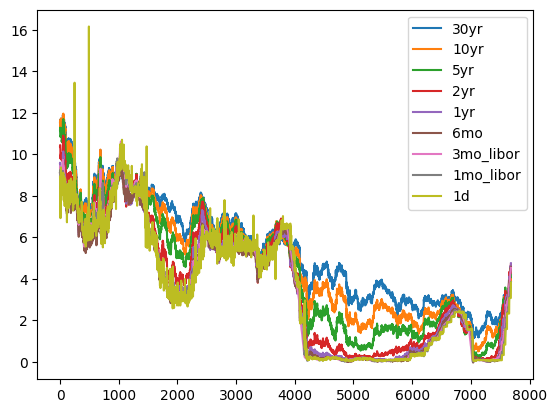

In [28]:
df.plot()

In [29]:
ma = df_recon.set_index(df_index).resample("M").mean()

# ACM

In [30]:
def vec(x):
    return np.reshape(x, (-1, 1))
def vec_quad_form(x):
    return vec(np.outer(x, x))

#rx_maturities = (6, 18, 24, 36, 48, 60, 84, 120) 
rx_maturities = (360, 120, 60, 24, 12, 6, 3, 1) 
n_maturities = 9
K = 3

ttm = np.arange(1.0, n_maturities + 1.0)[np.newaxis, :] / 12.0
logPrices = -df_recon.to_numpy()*ttm
rf = -logPrices[:-1, [0]]
rx = logPrices[1:, :-1] - logPrices[:-1, 1:] - rf

In [31]:
np.shape(df_recon.to_numpy())

(7684, 9)

In [32]:
np.shape(rx)

(7683, 8)

In [33]:
np.shape(recon)

(7684, 3)

In [34]:
#X = components.T
X = recon.T
t = len(df_recon)-1

X_lhs = X[:, 1:]  #X_t+1. Left hand side of VAR.
X_rhs = np.vstack((np.ones((1, t)), X[:, 0:-1])) #X_t and a constant.
var_coeffs = (X_lhs @ np.linalg.pinv(X_rhs))
mu = var_coeffs[:, [0]]
phi = var_coeffs[:, 1:]

v = X_lhs - var_coeffs @ X_rhs
Sigma = v @ v.T / t

In [35]:
#selected_rx = rx[:, [x - 2 for x in rx_maturities]].T  # Offset by 2 since index 0 is excess return on a 2m bond
selected_rx = rx[:, :-1].T
N = selected_rx.shape[0]
Z = np.vstack((np.ones((1, t)), v, X[:, 0:-1]))  #Innovations and lagged X
abc = selected_rx @ np.linalg.pinv(Z)
E = selected_rx - abc @ Z
sigmasq_ret = np.sum(E * E) / E.size

a = abc[:, [0]]
beta = abc[:, 1:K+1].T
c = abc[:, K+1:]

In [36]:
# Step (3) of the three-step procedure: Run cross-sectional regressions
BStar = np.squeeze(np.apply_along_axis(vec_quad_form, 1, beta.T))
lambda1 = np.linalg.pinv(beta.T) @ c
lambda0 = np.linalg.pinv(beta.T) @ (a + 1/2 * (BStar @ vec(Sigma) + sigmasq_ret))

In [37]:
# Run bond pricing recursions
A = np.zeros((1, n_maturities))
B = np.zeros((K, n_maturities))

delta = rf.T @ np.linalg.pinv(np.vstack((np.ones((1, t)), X[:, 0:-1])))
delta0 = delta[[0], [0]]
delta1 = delta[[0], 1:]

A[0, 0] = - delta0
B[:, 0] = - delta1

for i in range(0, n_maturities - 1):
    A[0, i+1] = A[0, i] + B[:, i].T @ (mu - lambda0) + 1/2 * (B[:, i].T @ Sigma @ B[:, i] + 0 * sigmasq_ret) - delta0
    B[:, i+1] = B[:, i] @ (phi - lambda1) - delta1



<Figure size 921.6x691.2 with 0 Axes>

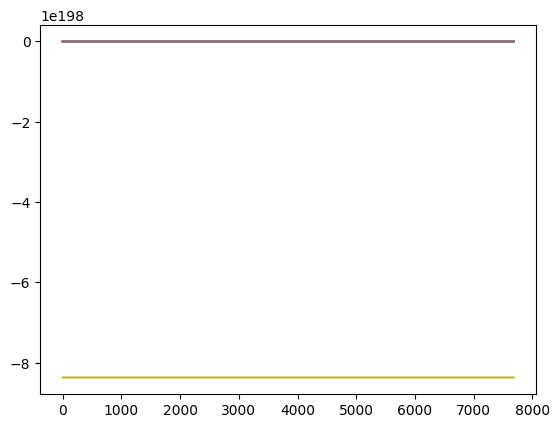

In [38]:
# Construct fitted yields
fittedLogPrices = (A.T + B.T @ X).T
fittedYields = - fittedLogPrices / ttm

plt.interactive(True)
plt.figure(dpi=144)
fig, axes = plt.subplots()

axes.plot(fittedYields, label = "Reconverted Yields")
plt.show()

/var/folders/2z/08m68qw50192x877gr0l5lzm0000gn/T/ipykernel_7681/1597040946.py:5: RuntimeWarning: overflow encountered in square
  temp_rmse = np.sqrt(np.mean((fittedYields[:,i]-np.array(df.iloc[:,i]))**2))


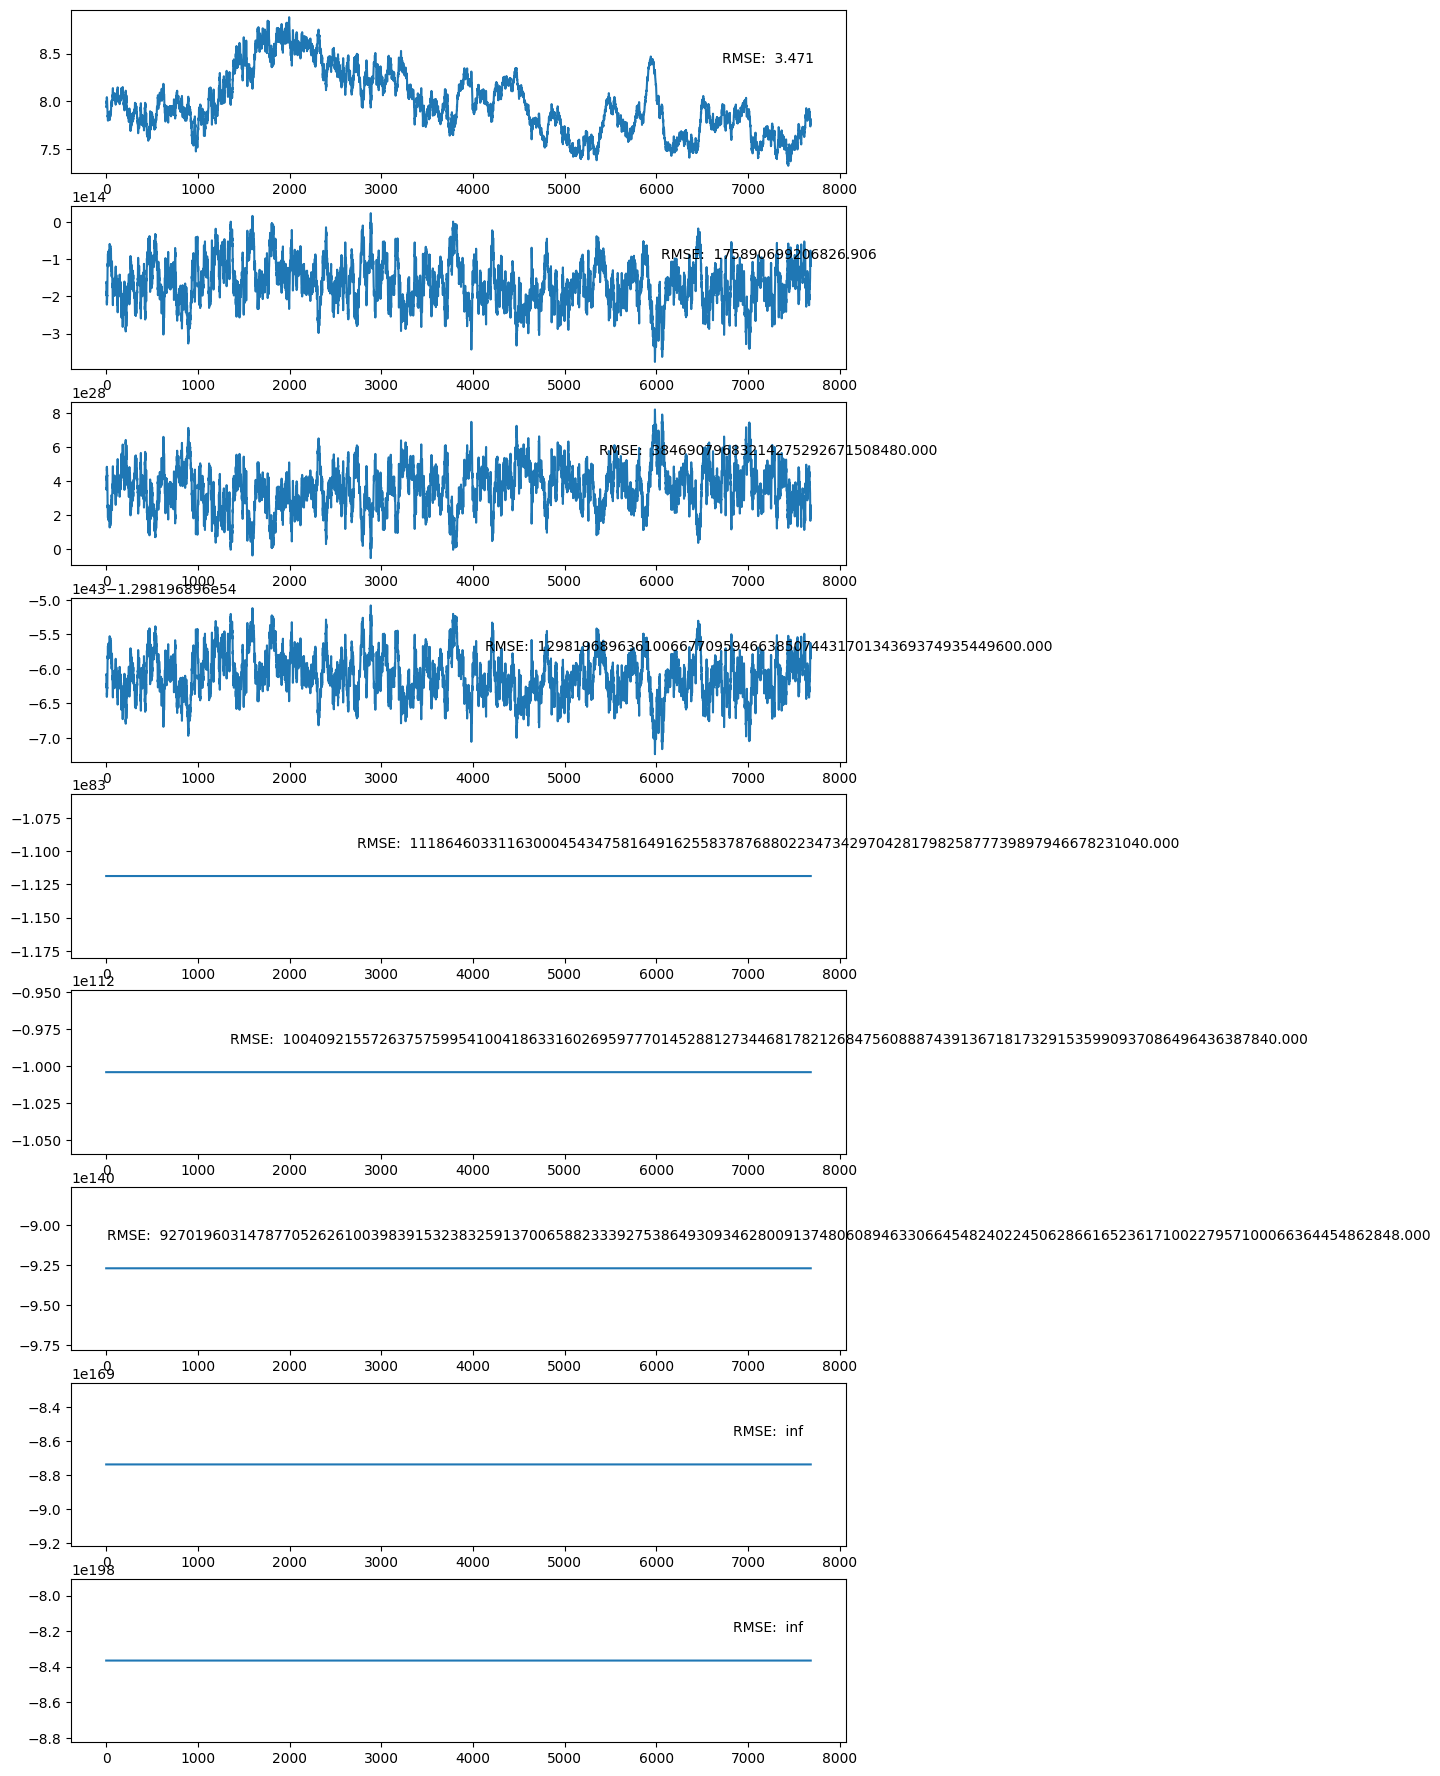

In [39]:
fig, axs = plt.subplots(len(fittedYields[0]), figsize=(10,22.5))
#fig.suptitle('Subplots of reconvert above')
for i in range(len(fittedYields[0])):
    axs[i].plot(fittedYields[:,i])
    temp_rmse = np.sqrt(np.mean((fittedYields[:,i]-np.array(df.iloc[:,i]))**2))
    axs[i].text(
        0.9, 0.7, 
        "RMSE: {rmse: .3f}".format(rmse = temp_rmse), 
        horizontalalignment='center', 
        verticalalignment='center', 
        transform=axs[i].transAxes)

<AxesSubplot: >

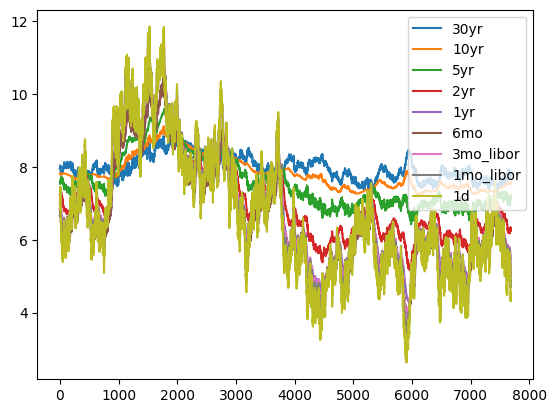

In [40]:
df_recon.plot()

## Chen

In [41]:
from dataclasses import dataclass
from typing import Optional, NoReturn


@dataclass
class ChenParams:
    """CIR process params, 2ab has to be larger or equal then c^2."""

    kappa: float
    nu: float
    zeta: float
    alpha: float
    mu: float
    beta: float
    eta: float

    def __post_init__(self) -> Optional[NoReturn]:
    #    if 2 * self.a * self.b < self.c ** 2:
    #        raise ValueError("2ab has to be less than or equal to c^2.")
        return None

In [42]:
def _validate_not_nan(dsigma_t: Any) -> Optional[NoReturn]:
    if np.isnan(dsigma_t).any():
        print(dsigma_t)
        raise ValueError(
            "CIR process simulation crashed, check your CIR_params. "
            + "Maybe choose a smaller c value."
        )
    return None

def generateChenRate(
    dW: np.ndarray,
    kappa: float,
    theta: np.ndarray,
    sigma: np.ndarray,
    start: Optional[float] = None
):
    N = len(dW)
    T = len(dW[0])
    rate_t = np.zeros((N, T), np.float64)
    if start == None:
        rate_t[:,0] = theta[:,0]
    else:
        rate_t[:,0] = start
    for t in range(1, T):
        d_rate_t = (
            kappa * (theta[:, t-1] - rate_t[:, t-1]) 
            + np.sqrt(rate_t[:,t-1])*np.sqrt(sigma[:,t-1])*dW[:,t]
        )
        rate_t[:,t] = (d_rate_t + rate_t[:, t-1])
    return rate_t

def getChen(
    N: int,
    T: int,
    params: ChenParams,
    start: Optional[float] = None,
    random_state: Optional[int] = None
):
    rand_mat = np.random.randint(1_000_000, size=3)
    dW_1 = brownian_motion.get_dW(N, T, rand_mat[0])
    theta_param = CIRParams(params.nu, params.zeta, params.alpha)
    sigma_param = CIRParams(params.mu, params.beta, params.eta)
    theta = get_CIR_process(N,T,theta_param)
    sigma = get_CIR_process(N,T,sigma_param)
    print("next:")
    rate = generateChenRate(dW_1, params.kappa, theta, sigma, start)
    
    return rate

In [43]:
def estimateChen(rate: np.ndarray, w_drift = 252, w_vol = 252):
    T = len(rate)
    
    if w_drift >= T or w_vol >= T:
        raise ValueError("Window should be shorter than total time")
    
    # drift
    drift = np.asarray(pd.DataFrame(rate.T).rolling(w_drift).mean()).T[:,(w_drift-1):][0]
    drift_param = estimate_CIR_params(drift)
    
    # volatility:
    vol = np.asarray(pd.DataFrame(rate.T).rolling(w_vol).std()).T[:,(w_vol-1):][0]
    vol_param = estimate_CIR_params(vol)
    
    # estimating kappa
    w = max(w_drift, w_vol)
    #d = abs(w_drift - w_vol)
    rate = rate[w-2:]
    rate_sqrt = np.sqrt(rate[:-1])
    y = np.diff(rate)/rate_sqrt
    x = drift/rate_sqrt - rate_sqrt
    #x = drift[int(d/2):-int(d/2)]/rate_sqrt - rate_sqrt
    reg = LinearRegression(fit_intercept=False)
    #print(x.reshape(-1,1))
    reg.fit(x.reshape(-1,1),y)
    kappa = reg.coef_[0]
    
    
    return ChenParams(kappa, drift_param.a, drift_param.b, drift_param.c, vol_param.a, vol_param.b, vol_param.c)

In [44]:
est_chen_level = estimateChen(proc_level)
est_chen_level

ChenParams(kappa=0.005374959738193666, nu=0.00028134546532473606, zeta=0.7706371860216973, alpha=0.005333437148107588, mu=-0.00030372100998198325, beta=0.28334805395480817, eta=0.007391842147886008)

### Problems: Chen model

Chen model performs badly(with nans meaning hitting negative rates) might because:

From the plot of level (PCA component) according to our data, the curve is generally decreasing with a comparatively slight upward trend (maybe representing a mean reversion, maybe not) at the tail. As Chen model consider drift (rolling averages) and volatility with CIR process, the approximation of drift indicates a CIR process with mean $\zeta$ close to zero while the volatility $\alpha$ "too large for $\zeta$ to control", as the CIR model believes that our data of level represents the state of mean-reverting.

We may try to modify the model of drift approximating, either switch to other process or to other indicating values.

In [45]:
# RProblem: why always rounding to integer when adding floats to array???
getChen(1,1000, est_chen_level, start = proc_level[0])

next:


/var/folders/2z/08m68qw50192x877gr0l5lzm0000gn/T/ipykernel_7681/3505331407.py:27: RuntimeWarning: invalid value encountered in sqrt
  + np.sqrt(rate_t[:,t-1])*np.sqrt(sigma[:,t-1])*dW[:,t]


array([[29.28090615, 26.39953603, 26.80813881, 28.29152002, 27.94007578,
        33.56819679, 36.54944726, 38.35437025, 40.54593883, 37.74371554,
        36.48518288, 35.53575473, 33.94831044, 32.95662172, 31.9530764 ,
        34.0049938 , 32.95683649, 31.48850674, 32.25984364, 28.60762348,
        27.05373189, 21.91966915, 20.73464547, 22.53538659, 21.03726909,
        18.77295217, 13.82622127, 12.36153145, 11.59929973, 11.33113068,
        11.39459591,  9.78478158,  9.65053568,  9.74988672,  8.74173052,
        11.05447516, 10.4146311 ,  8.11313645,  8.67928705,  7.73692251,
         9.13813466,  9.86784604, 11.1811477 ,  9.96178   , 11.71989967,
         7.61752194,  6.85602315,  7.43572725,  9.23316404,  6.32982239,
         8.18086576,  5.46639522,  4.13180042,  3.48055705,  4.88860627,
         2.94396681,  2.37224992,  3.23697286,  2.57926719,  3.60456338,
         3.84501074,  4.79201432,  4.0312701 ,  5.89398083,  5.75256795,
         5.87652855,  5.67324007,  4.16622175,  3.9

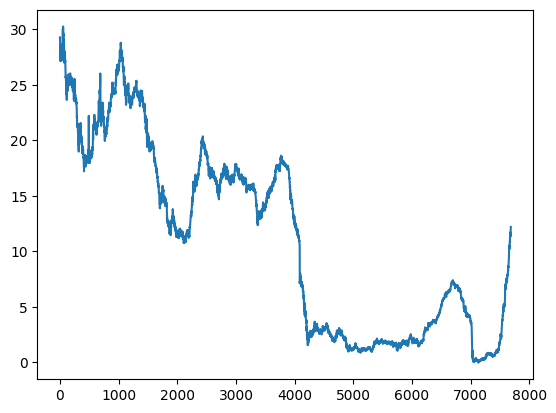

In [46]:
plt.plot(proc_level)

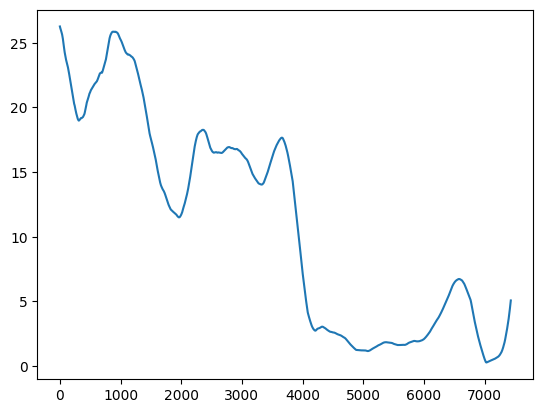

In [47]:
plt.plot(np.asarray(pd.DataFrame(proc_level.T).rolling(252).mean()).T[:,(252-1):][0])

CIRParams(a=0.00028134546532473606, b=0.7706371860216973, c=0.005333437148107588)


array([[0.77063719, 0.76851677, 0.76241098, 0.759988  , 0.76573819,
        0.7736505 , 0.77526434, 0.77686233, 0.76789395, 0.77368934,
        0.77136993, 0.77554978, 0.77113134, 0.77030051, 0.76781232,
        0.75739087, 0.75441568, 0.75373375, 0.75921613, 0.76669374,
        0.76503629, 0.76653419, 0.77284578, 0.77592531, 0.76535869,
        0.76898345, 0.77249523, 0.77239363, 0.77181581, 0.7729935 ,
        0.77414224, 0.77247255, 0.77552208, 0.77491261, 0.77651013,
        0.77143058, 0.7662788 , 0.76606313, 0.76547334, 0.75656791,
        0.75439072, 0.75936612, 0.75825942, 0.76222396, 0.76027655,
        0.75530368, 0.75477237, 0.75856288, 0.75400032, 0.75087983,
        0.74653284, 0.74919456, 0.74868041, 0.76018222, 0.76266426,
        0.77093629, 0.76574313, 0.76975541, 0.78244462, 0.77617304,
        0.77237231, 0.77465055, 0.77271273, 0.77374349, 0.77288736,
        0.76610527, 0.76347217, 0.7641517 , 0.76474889, 0.76001845,
        0.75504016, 0.75489946, 0.75039439, 0.75

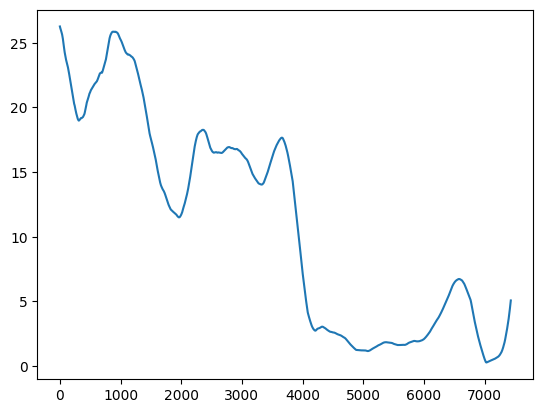

In [48]:
plt.plot(np.asarray(pd.DataFrame(proc_level.T).rolling(252).mean()).T[:,(252-1):][0])
print(
    estimate_CIR_params(np.asarray(pd.DataFrame(proc_level.T).rolling(252).mean()).T[:,(252-1):][0])
)
get_CIR_process(
    1,1000,estimate_CIR_params(np.asarray(pd.DataFrame(proc_level.T).rolling(252).mean()).T[:,(252-1):][0])
)

CIRParams(a=-0.00030372100998198325, b=0.28334805395480817, c=0.007391842147886008)


array([[0.28334805, 0.28063531, 0.27694309, 0.27569779, 0.27235666,
        0.27467548, 0.27858342, 0.27798896, 0.2779986 , 0.27442192,
        0.26957855, 0.26464027, 0.26158822, 0.26176969, 0.26297587,
        0.26189144, 0.2664383 , 0.27076269, 0.26568467, 0.26592257,
        0.26396825, 0.26670608, 0.27060605, 0.27368497, 0.27903574,
        0.26942559, 0.27352767, 0.27319281, 0.27380856, 0.27095958,
        0.26121627, 0.25943351, 0.26255064, 0.25777832, 0.2557127 ,
        0.25629317, 0.25522785, 0.26204317, 0.26390843, 0.26151914,
        0.26639465, 0.26416175, 0.25499354, 0.25709729, 0.25347121,
        0.25469822, 0.24744802, 0.24710982, 0.24867532, 0.25306168,
        0.25213547, 0.2574395 , 0.25402808, 0.25437044, 0.25376465,
        0.256395  , 0.261564  , 0.26640114, 0.2643497 , 0.26700877,
        0.26992547, 0.26465967, 0.27047882, 0.266111  , 0.26907923,
        0.26885257, 0.27207633, 0.26304065, 0.26488657, 0.26380529,
        0.2659598 , 0.26307089, 0.26701973, 0.27

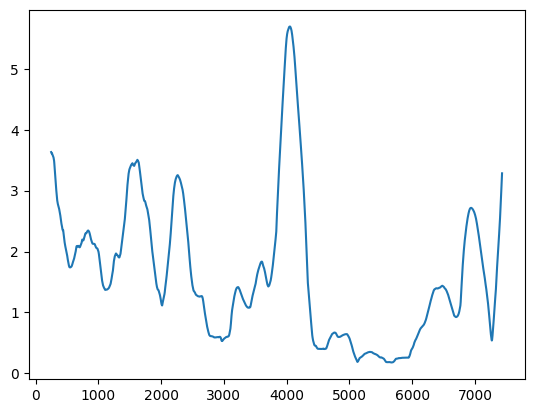

In [49]:
plt.plot(np.asarray(pd.DataFrame(proc_level.T).rolling(500).std()).T[:,(252-1):][0])
print(
    estimate_CIR_params(np.asarray(pd.DataFrame(proc_level.T).rolling(252).std()).T[:,(252-1):][0])
)
get_CIR_process(
    1,1000,estimate_CIR_params(np.asarray(pd.DataFrame(proc_level.T).rolling(252).std()).T[:,(252-1):][0])
)